## Basis functions--multiclass classification

In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils
import torchviz

In [2]:
#rk4 integrator

def rk4(func, tk, yk, dt):
    
    f1 = func(tk, yk)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)))
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)))
    f4 = func(tk + dt, yk + (f3 * dt))

    return yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

In [3]:
dataset_folder = "D:/Robotics/neural-fly-main/neural-fly-main/data/experiment"

features1 = ['v']
RawData1 = utils.load_data(dataset_folder)
Data1 = utils.format_data(RawData1, features=features1)

In [4]:
Data1[21][0]

array([[-0.04476171, -0.01667862, -0.03411659],
       [-0.03251101, -0.01302119, -0.02855639],
       [-0.03705182, -0.01422076, -0.02494361],
       ...,
       [-1.03388135,  0.01825404,  1.46596738],
       [-1.03871028,  0.01942204,  1.45967078],
       [-1.04443511,  0.01725874,  1.45530389]])

In [5]:
type(Data1[21][0])

numpy.ndarray

In [6]:
v = np.zeros((2511,3),dtype = np.float64) #first input feature
for row in range(len(v)):
    for column in range(3):
        v[row][column] = Data1[21][0][row][column]
v.shape

(2511, 3)

In [7]:
v2 = np.zeros((2511,3),dtype = np.float64) #first input feature
for row in range(len(v2)):
    for column in range(3):
        v2[row][column] = Data1[22][0][row][column]
v2.shape

(2511, 3)

In [8]:
features2 = ['T_sp']
RawData2 = utils.load_data(dataset_folder)
Data2 = utils.format_data(RawData2, features=features2)

In [9]:
fu = np.zeros((2511,3),dtype = np.float64)
for row in range(len(fu)):
    fu[row][2] = Data2[21][0][row][0]
fu.shape

(2511, 3)

In [10]:
fu2 = np.zeros((2511,3),dtype = np.float64)
for row in range(len(fu2)):
    fu2[row][2] = Data2[22][0][row][0]
fu2.shape

(2511, 3)

In [11]:
R = np.zeros((2511,3,3),dtype = np.float64)
features3 = ['R']
RawData3 = utils.load_data(dataset_folder)
Data3 = utils.format_data(RawData3, features=features3)

In [12]:
for matrix in range(len(R)):
    for row in range(3):
        for column in range(3):
            R[matrix][row][column] = Data3[21][0][matrix][row][column]

In [13]:
R2 = np.zeros((2511,3,3),dtype = np.float64)
for matrix in range(len(R2)):
    for row in range(3):
        for column in range(3):
            R2[matrix][row][column] = Data3[22][0][matrix][row][column]

In [14]:
Rfu2 = np.zeros((2511,3),dtype = np.float64) #second input feature
for row in range(len(Rfu2)):
    Rfu2[row] = np.matmul(R2[row],fu2[row])
Rfu2.shape

(2511, 3)

In [15]:
Rfu = np.zeros((2511,3),dtype = np.float64) #second input feature
for row in range(len(Rfu)):
    Rfu[row] = np.matmul(R[row],fu[row])
Rfu.shape

(2511, 3)

In [16]:
acc = np.zeros((2511,3),dtype = np.float64) # actual acceleration
for ele in range(2510):
    acc[ele] = (v[ele+1]-v[ele])/0.02
acc[2510] = acc[2509]

In [17]:
acc2 = np.zeros((2511,3),dtype = np.float64) # actual acceleration
for ele in range(2510):
    acc2[ele] = (v2[ele+1]-v2[ele])/0.02
acc2[2510] = acc2[2509]

In [18]:
acc.shape

(2511, 3)

In [19]:
features4 = ['p']
RawData4 = utils.load_data(dataset_folder)
Data4 = utils.format_data(RawData4, features=features4)

In [20]:
pos = np.zeros((2511,3),dtype = np.float64)
for row in range(len(pos)):
    for column in range(3):
        pos[row][column] = Data4[21][0][row][column]
pos.shape

(2511, 3)

In [21]:
pos2 = np.zeros((2511,3),dtype = np.float64)
for row in range(len(pos2)):
    for column in range(3):
        pos2[row][column] = Data4[22][0][row][column]
pos2.shape

(2511, 3)

In [88]:
features5 = ['pwm']
RawData5 = utils.load_data(dataset_folder)
Data5 = utils.format_data(RawData5, features=features5)

In [101]:
Data5[21][0]

array([[0.97552185, 1.0749785 , 0.93948967, 1.0563281 ],
       [0.97249466, 1.08192196, 0.92921129, 1.07187378],
       [0.9531745 , 1.10491846, 0.92413619, 1.07616389],
       ...,
       [0.97212025, 1.0732439 , 0.92712627, 1.03111808],
       [0.96953049, 1.05622842, 0.91250544, 1.02718372],
       [0.96512115, 1.03982932, 0.89771999, 1.02164738]])

In [102]:
pwm = np.zeros((2511,4),dtype = np.float64)
for row in range(len(pwm)):
    for col in range(4):
        pwm[row][col] = Data5[21][0][row][col]

In [103]:
pwm2 = np.zeros((2511,4),dtype = np.float64)
for row in range(len(pwm2)):
    for col in range(4):
        pwm2[row][col] = Data5[22][0][row][col]

In [22]:
def basis_functions(a, b):
    a_basis = torch.cat([
        a, 
        a**2, 
        torch.cos(a),
        torch.sin(a),
        torch.cos(2*a),
        torch.sin(2*a),
        torch.cos(3*a),
        torch.sin(3*a),
        torch.cos(a)*torch.sin(a),
        torch.cos(2*a)*torch.sin(2*a)
    ], dim=-1).view(-1,3)
    
    b_basis = torch.cat([
        b, 
        b**2, 
        torch.cos(b),
        torch.sin(b),
        torch.cos(2*b),
        torch.sin(2*b),
        torch.cos(3*b),
        torch.sin(3*b),
        torch.cos(b)*torch.sin(b),
        torch.cos(2*b)*torch.sin(2*b)
    ], dim=-1).view(-1,3)
    
    return a_basis, b_basis

class MultiClassNN(nn.Module):
    def __init__(self):
        super(MultiClassNN, self).__init__()
        self.fc1 = nn.Linear(6, 20)
        self.adaptive_relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(20, 45)
        self.adaptive_relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(45, 65)
        self.adaptive_relu3 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(65, 1)

    def forward(self, a, b):
        a_basis, b_basis = basis_functions(a, b)
        
        x = torch.cat((a_basis, b_basis), dim=-1)
        
        x = self.fc1(x)
        
        x = self.adaptive_relu1(x)
        x = self.fc2(x)
        x = self.adaptive_relu2(x)
        x = self.fc3(x)
        x = self.adaptive_relu3(x)
        
        x = self.fc4(x)
        coeffs = F.softmax(x, dim= 0)
        a_accel_pred = torch.sum(torch.mm(torch.transpose(coeffs,0,1) , a_basis), dim=0, keepdim=True)
        b_accel_pred = torch.sum(torch.mm(torch.transpose(coeffs,0,1) , b_basis), dim=0, keepdim=True)
        
        accel_pred = a_accel_pred + b_accel_pred
    
        accel_pred = torch.sum(accel_pred, dim=0, keepdim=True)        
        return accel_pred, coeffs

model = MultiClassNN()

# Define the loss function
def custom_loss(accel, accel_pred, coeffs):
    loss = torch.mean((accel - accel_pred)**2)
    
    return loss

# Define the optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(acc[i]).view(1, -1)
        accel_pred_i, coeffs_i = model(v_i, Rfu_i)
        loss_i = custom_loss(accel_i, accel_pred_i, coeffs_i)
        loss_i.backward()
        loss += loss_i.item()
        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")




Epoch [10/100], Loss: 1.5328
Epoch [20/100], Loss: 1.5408
Epoch [30/100], Loss: 1.4889
Epoch [40/100], Loss: 1.4141
Epoch [50/100], Loss: 1.4165
Epoch [60/100], Loss: 1.4132
Epoch [70/100], Loss: 1.4342
Epoch [80/100], Loss: 1.3640
Epoch [90/100], Loss: 1.3552
Epoch [100/100], Loss: 1.3373


In [23]:
accel_prediction = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i, coeffs_i = model(test_v_i, test_Rfu_i)
    accel_prediction[i] = accel_pred_i

In [24]:
accel_prediction = accel_prediction.detach().numpy()


In [25]:
#mse
error = 0.0
for ele in range(2511):
    temp = np.square(np.subtract(acc[ele],accel_prediction[ele]))
    error = error + temp
error = error/2511
error

array([0.62247102, 0.1168489 , 3.38478271])

In [26]:
t = np.linspace(0.0,50.2,2511)

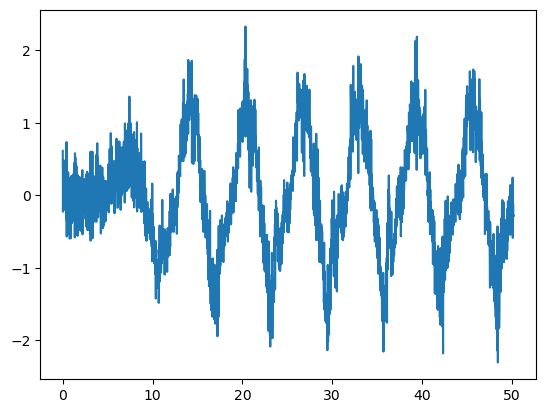

In [27]:
plt.plot(t,acc[:,0])
plt.show()

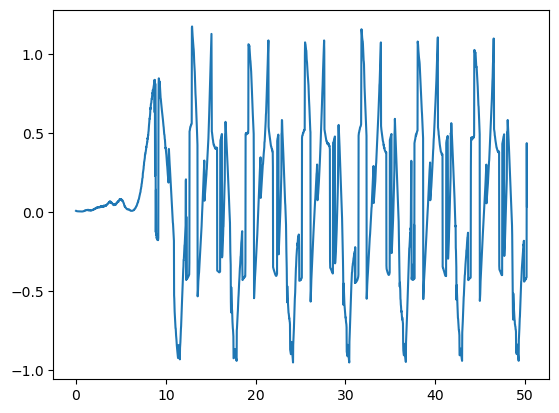

In [28]:
plt.plot(t,accel_prediction[:,0])
plt.show()

## Incorporating PINN

In [29]:
def basis_functions(a, b):
    a_basis = torch.cat([
        a, 
        a**2, 
        torch.cos(a),
        torch.sin(a),
        torch.cos(2*a),
        torch.sin(2*a),
        torch.cos(3*a),
        torch.sin(3*a),
        torch.cos(a)*torch.sin(a),
        torch.cos(2*a)*torch.sin(2*a)
    ], dim=-1).view(-1,3)
    
    b_basis = torch.cat([
        b, 
        b**2, 
        torch.cos(b),
        torch.sin(b),
        torch.cos(2*b),
        torch.sin(2*b),
        torch.cos(3*b),
        torch.sin(3*b),
        torch.cos(b)*torch.sin(b),
        torch.cos(2*b)*torch.sin(2*b)
    ], dim=-1).view(-1,3)
    
    return a_basis, b_basis

class PINN(nn.Module):
    def __init__(self, m, k):
        super(PINN, self).__init__()
        self.m = m
        self.k = k
        self.fc1 = nn.Linear(6, 20)
        self.adaptive_relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(20, 45)
        self.adaptive_relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(45, 65)
        self.adaptive_relu3 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(65, 1)

    def forward(self, v, Rfu):
        a_gravity = torch.tensor([0., 0., -9.81])  # acceleration due to gravity
        v_norm = torch.norm(v, dim=-1, keepdim=True)
        #a_drag = -self.k * v_norm**2 * v / self.m
        a_thrust = Rfu / self.m

        #a = a_thrust + a_drag + a_gravity  
        a = a_thrust
        a_basis, b_basis = basis_functions(v, Rfu)
        x = torch.cat((a_basis, b_basis), dim=-1)
        
        x = self.fc1(x)
        
        x = self.adaptive_relu1(x)
        x = self.fc2(x)
        x = self.adaptive_relu2(x)
        x = self.fc3(x)
        x = self.adaptive_relu3(x)
        
        x = self.fc4(x)
        coeffs = F.softmax(x, dim= 0)
        a_accel_pred = torch.sum(torch.mm(torch.transpose(coeffs,0,1) , a_basis), dim=0, keepdim=True)
        b_accel_pred = torch.sum(torch.mm(torch.transpose(coeffs,0,1) , b_basis), dim=0, keepdim=True)
        
        accel_pred = a_accel_pred + b_accel_pred + a
    
        accel_pred = torch.sum(accel_pred, dim=0, keepdim=True)        
        return accel_pred, coeffs

model = PINN(1,0.01)

# Define the loss function
def custom_loss(accel, accel_pred, coeffs):
    loss = torch.mean((accel - accel_pred)**2)
    
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)


num_epochs = 100
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(acc[i]).view(1, -1)
        accel_pred_i, coeffs_i = model(v_i, Rfu_i)
        loss_i = custom_loss(accel_i, accel_pred_i, coeffs_i)
        loss_i.backward()
        loss += loss_i.item()
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")



Epoch [10/100], Loss: 1.5564
Epoch [20/100], Loss: 1.5225
Epoch [30/100], Loss: 1.5479
Epoch [40/100], Loss: 1.4340
Epoch [50/100], Loss: 1.4301
Epoch [60/100], Loss: 1.4311
Epoch [70/100], Loss: 1.4181
Epoch [80/100], Loss: 1.4336
Epoch [90/100], Loss: 1.4105
Epoch [100/100], Loss: 1.4206


In [30]:
accel_prediction = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i, coeffs_i = model(test_v_i, test_Rfu_i)
    accel_prediction[i] = accel_pred_i

In [31]:
accel_prediction = accel_prediction.detach().numpy()

In [32]:
#mse
error = 0.0
for ele in range(2511):
    temp = np.square(np.subtract(acc[ele],accel_prediction[ele]))
    error = error + temp
error = error/2511
error

array([0.68045511, 0.11790979, 3.42281657])

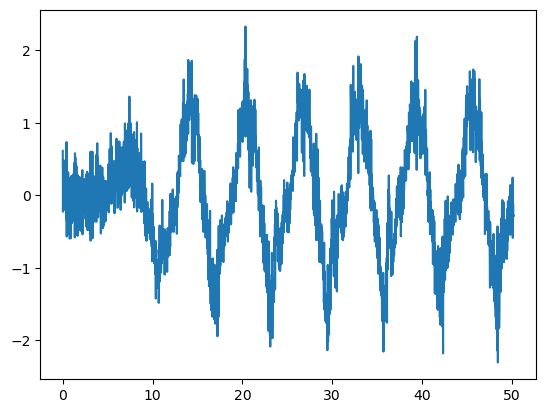

In [33]:
plt.plot(t,acc[:,0])
plt.show()

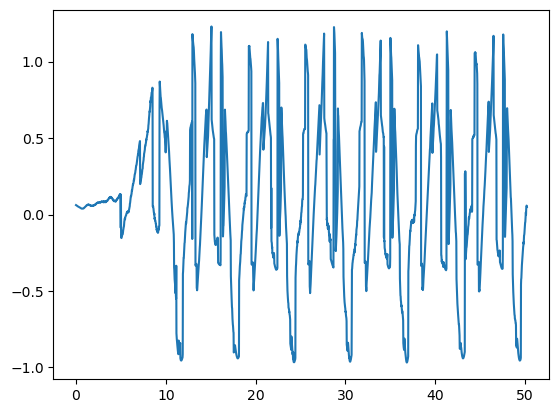

In [34]:
plt.plot(t,accel_prediction[:,0])
plt.show()

### try learning the kernel functions 

#### Model1 (v)

In [24]:
from sklearn.model_selection import train_test_split
import torchviz

torch.autograd.set_detect_anomaly(True)

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(50, 100)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(100, 50)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.fc2(x)
        x = self.gelu2(x)
        x = self.fc3(x)
        x = self.gelu3(x)
        x = self.fc4(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33, random_state=42)

num_epochs = 150
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
   
   
    optimizer.step()
    train_loss /= len(v_train)
    if epoch % 10 == 0:
        print("Epoch: {}, train loss : {:.4f}".format(epoch, train_loss))
    

Epoch: 0, train loss : 1.5708
Epoch: 10, train loss : 0.8083
Epoch: 20, train loss : 0.6058
Epoch: 30, train loss : 0.4229
Epoch: 40, train loss : 0.3214
Epoch: 50, train loss : 0.2582
Epoch: 60, train loss : 0.2195
Epoch: 70, train loss : 0.1951
Epoch: 80, train loss : 0.1715
Epoch: 90, train loss : 0.1603
Epoch: 100, train loss : 0.1592
Epoch: 110, train loss : 0.1581
Epoch: 120, train loss : 0.1574
Epoch: 130, train loss : 0.1570
Epoch: 140, train loss : 0.1610


Mean Absolute Error: 0.29548819741290727
Mean Squared Error: 0.16941717176832183


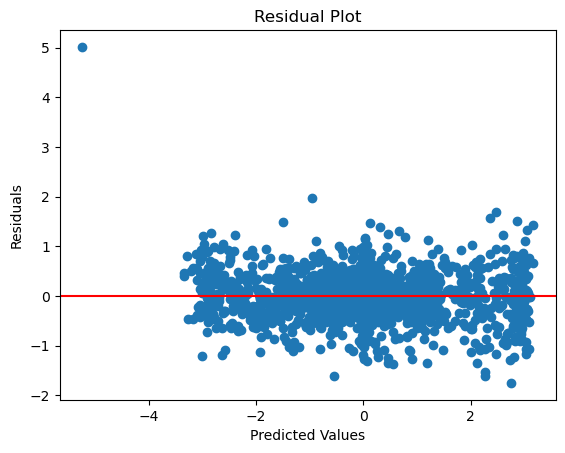

In [296]:
from sklearn.metrics import mean_squared_error

model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
mse = mean_squared_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [25]:
torch.save(model.state_dict(), 'model.pth')


In [297]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))

0.06729047297679736 0.11160238039058847 0.32905869058275


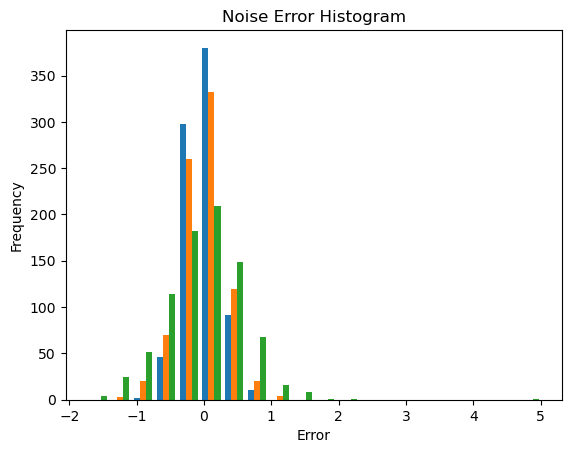

In [298]:
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

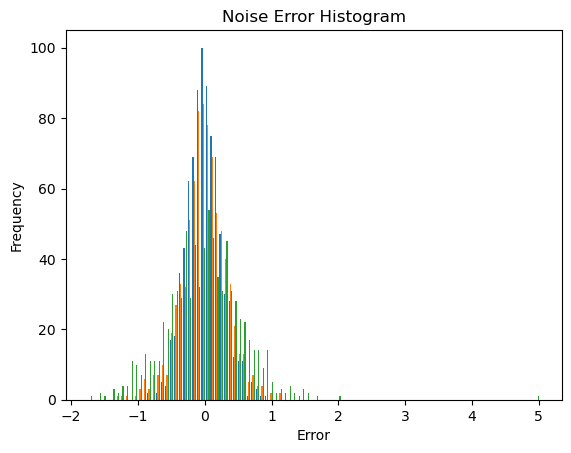

In [299]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [264]:
accel_prediction = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i = model(torch.cat((test_v_i, test_Rfu_i), dim=-1))
    #print(accel_pred_i)
    accel_prediction[i] = accel_pred_i

In [265]:
accel_prediction = accel_prediction.detach().numpy()

In [266]:
error = 0.0
for ele in range(2511):
    temp = np.square(np.subtract(acc[ele],accel_prediction[ele]))
    error = error + temp
error = error/2511
error

array([0.06567035, 0.11343313, 0.30257848])

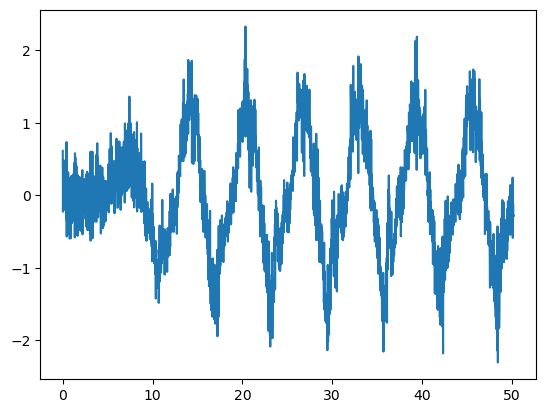

In [267]:
plt.plot(t,acc[:,0])
plt.show()

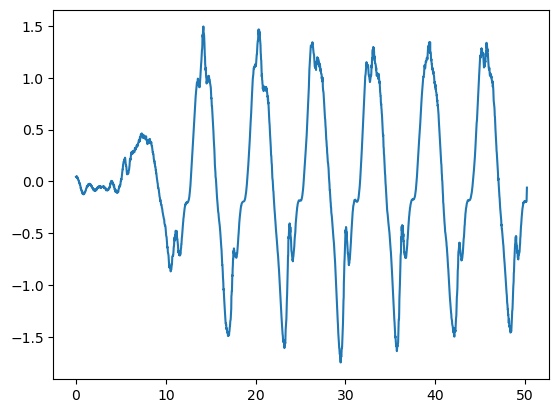

In [268]:
plt.plot(t,accel_prediction[:,0])
plt.show()

In [269]:
def acceleration(tk,yk):
    count = tk/0.02
    return accel_prediction[int(count)]

In [270]:
vel = np.zeros((2511,3),dtype = np.float64)
yk = v[0]
dt = 0.02
tk = 0
for ele in range(2510):
    ykplus1 = rk4(acceleration,tk,yk,dt)
    vel[ele] = ykplus1
    tk = tk+0.02
    yk = ykplus1 

In [271]:
def velocity(tk,yk):
    count = tk/0.02
    return vel[int(count)]

In [272]:
pos_reg = np.zeros((2511,3),dtype = np.float64)
xk = np.array([0.0,0.0,0.0])
dt = 0.02
tk = 0
for ele in range(2510):
    ykplus1 = rk4(velocity,tk,yk,dt)
    pos_reg[ele] = ykplus1
    tk = tk+0.02
    yk = ykplus1

In [273]:
pos_reg_dp = np.zeros((2509,3),dtype = np.float64)
for ele in range(2509):
    pos_reg_dp[ele] = pos_reg[ele]

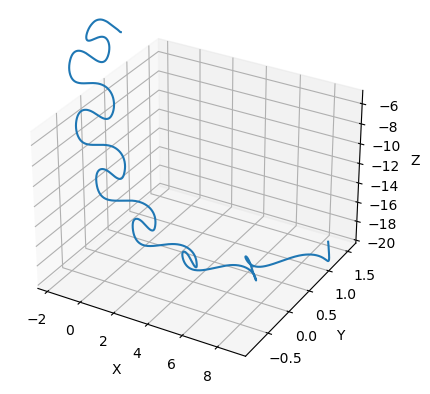

In [274]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_zlim3d([-20, -5])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot3D(pos_reg_dp[:,0],pos_reg_dp[:,1],pos_reg_dp[:,2])
plt.show()

In [275]:
dt = 0.02

#### Trying ablation by removing a few layers

In [276]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.fc2(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    if epoch % 10 == 0:
        print("Epoch: {}, train loss : {:.4f}".format(epoch, train_loss))
    

Epoch: 0, train loss : 1.5680
Epoch: 10, train loss : 1.4797
Epoch: 20, train loss : 1.3329
Epoch: 30, train loss : 1.0877
Epoch: 40, train loss : 0.7680
Epoch: 50, train loss : 0.4890
Epoch: 60, train loss : 0.3300
Epoch: 70, train loss : 0.2350
Epoch: 80, train loss : 0.1825
Epoch: 90, train loss : 0.1668
Epoch: 100, train loss : 0.1629
Epoch: 110, train loss : 0.1598
Epoch: 120, train loss : 0.1579
Epoch: 130, train loss : 0.1569
Epoch: 140, train loss : 0.1562
Epoch: 150, train loss : 0.1555
Epoch: 160, train loss : 0.1551
Epoch: 170, train loss : 0.1548
Epoch: 180, train loss : 0.1545
Epoch: 190, train loss : 0.1548


Mean Absolute Error: 0.2933093222299327


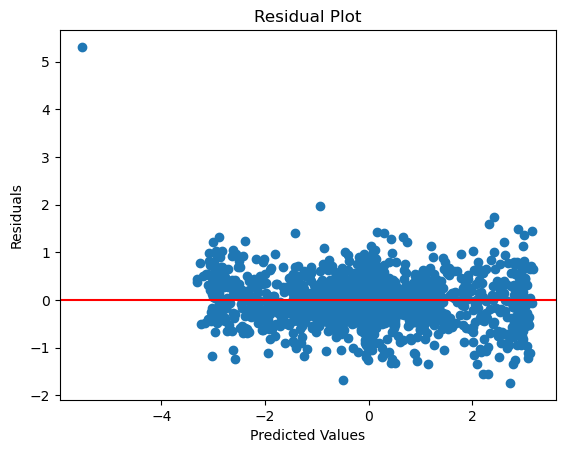

In [277]:
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [280]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))

0.06345538508395074 0.10777901507352478 0.33540665075967296


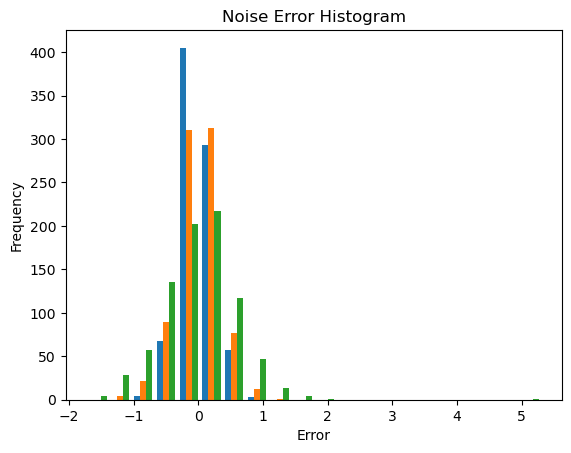

In [278]:
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

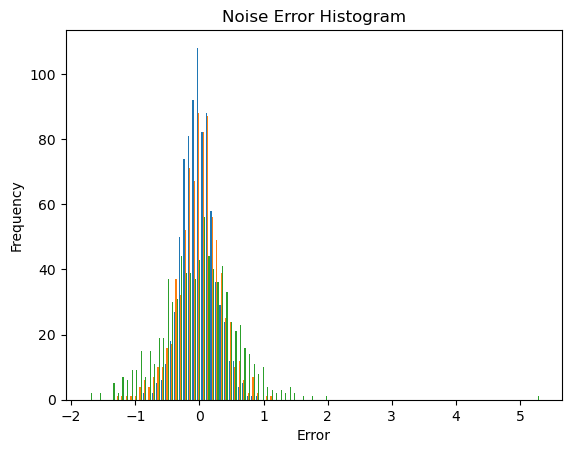

In [279]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#### Ablation 2

In [281]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    if epoch % 10 == 0:
        print("Epoch: {}, train loss : {:.4f}".format(epoch, train_loss))
    

Epoch: 0, train loss : 1.6085
Epoch: 10, train loss : 1.4733
Epoch: 20, train loss : 1.3196
Epoch: 30, train loss : 1.0877
Epoch: 40, train loss : 0.8141
Epoch: 50, train loss : 0.5640
Epoch: 60, train loss : 0.3869
Epoch: 70, train loss : 0.2815
Epoch: 80, train loss : 0.2203
Epoch: 90, train loss : 0.1916
Epoch: 100, train loss : 0.1770
Epoch: 110, train loss : 0.1686
Epoch: 120, train loss : 0.1633
Epoch: 130, train loss : 0.1600
Epoch: 140, train loss : 0.1579
Epoch: 150, train loss : 0.1566
Epoch: 160, train loss : 0.1557
Epoch: 170, train loss : 0.1549
Epoch: 180, train loss : 0.1543
Epoch: 190, train loss : 0.1538


Mean Absolute Error: 0.29549778862166626


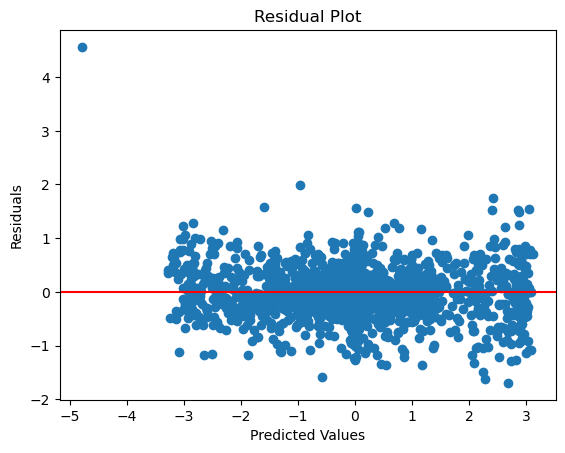

In [282]:
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

0.06879268479439891 0.10829762958068474 0.3266185268030701


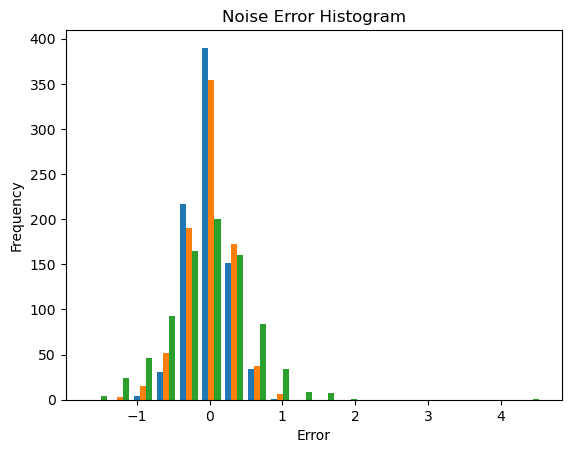

In [283]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

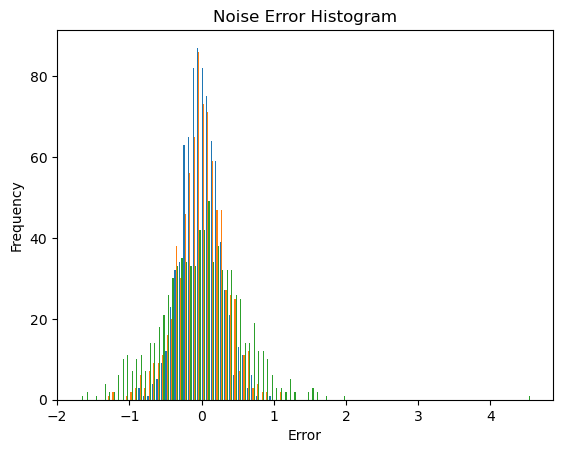

In [284]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#### Ablation 3

In [285]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 15)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(15, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    if epoch % 10 == 0:
        print("Epoch: {}, train loss : {:.4f}".format(epoch, train_loss))
    

Epoch: 0, train loss : 1.5885
Epoch: 10, train loss : 1.5254
Epoch: 20, train loss : 1.4673
Epoch: 30, train loss : 1.3787
Epoch: 40, train loss : 1.2517
Epoch: 50, train loss : 1.0910
Epoch: 60, train loss : 0.9067
Epoch: 70, train loss : 0.7210
Epoch: 80, train loss : 0.5490
Epoch: 90, train loss : 0.4089
Epoch: 100, train loss : 0.3039
Epoch: 110, train loss : 0.2372
Epoch: 120, train loss : 0.1979
Epoch: 130, train loss : 0.1814
Epoch: 140, train loss : 0.1743
Epoch: 150, train loss : 0.1706
Epoch: 160, train loss : 0.1684
Epoch: 170, train loss : 0.1667
Epoch: 180, train loss : 0.1652
Epoch: 190, train loss : 0.1637


Mean Absolute Error: 0.3055044078871316


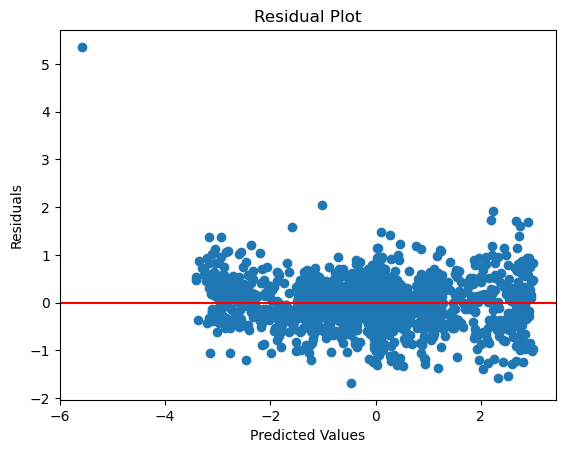

In [286]:
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

0.0773992405463697 0.11029013028270865 0.35438277217454045


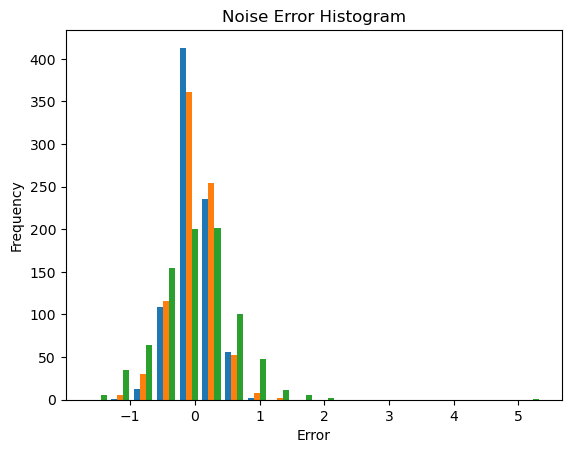

In [287]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

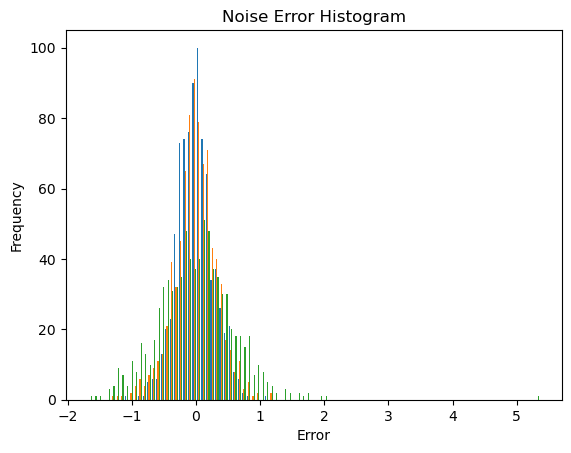

In [288]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#### Ablation 4

In [289]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 15)
        
        self.fc2 = nn.Linear(15, 3)

    def forward(self, x):
        x = self.fc1(x)
        
        x = self.fc2(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    if epoch % 10 == 0:
        print("Epoch: {}, train loss : {:.4f}".format(epoch, train_loss))
    

Epoch: 0, train loss : 1.6455
Epoch: 10, train loss : 1.5336
Epoch: 20, train loss : 1.4891
Epoch: 30, train loss : 1.4293
Epoch: 40, train loss : 1.3351
Epoch: 50, train loss : 1.1984
Epoch: 60, train loss : 1.0207
Epoch: 70, train loss : 0.8184
Epoch: 80, train loss : 0.6193
Epoch: 90, train loss : 0.4513
Epoch: 100, train loss : 0.3293
Epoch: 110, train loss : 0.2514
Epoch: 120, train loss : 0.2068
Epoch: 130, train loss : 0.1830
Epoch: 140, train loss : 0.1710
Epoch: 150, train loss : 0.1653
Epoch: 160, train loss : 0.1630
Epoch: 170, train loss : 0.1622
Epoch: 180, train loss : 0.1618
Epoch: 190, train loss : 0.1617


Mean Absolute Error: 0.29947789359634763


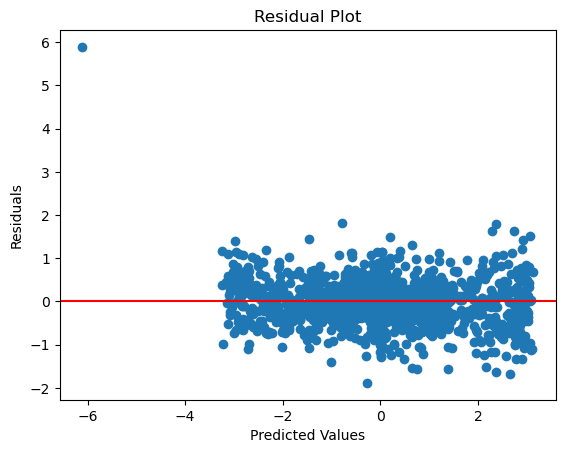

In [290]:
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
mse = mean_squared_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

0.06623047109190425 0.11012932808973334 0.3557973118792656


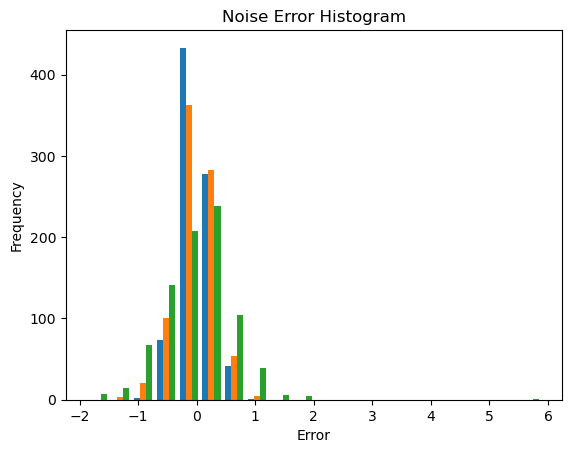

In [291]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

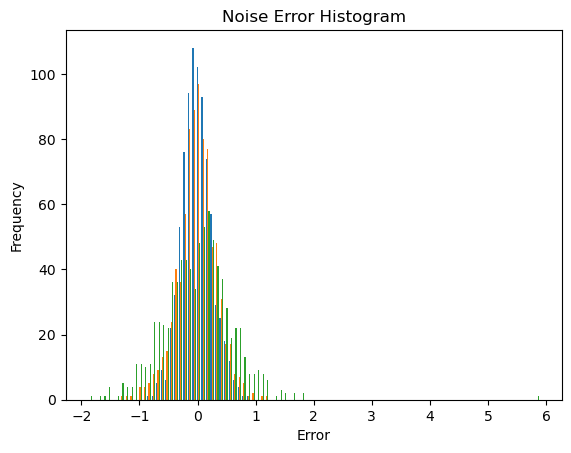

In [292]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#### Model2 (v2)

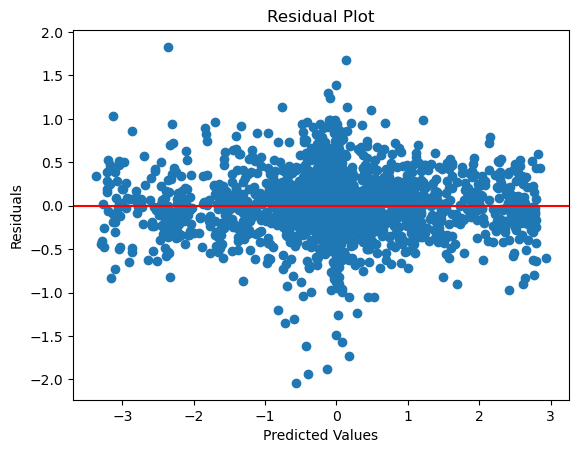

In [48]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(50, 100)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(100, 50)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.fc2(x)
        x = self.gelu2(x)
        x = self.fc3(x)
        x = self.gelu3(x)
        x = self.fc4(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v2, Rfu2, acc2, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    
# Make predictions using the trained model on the test set
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [49]:
accel_prediction2 = torch.zeros((2511, 3))
for i in range(len(v2)):
    test_v_i = torch.Tensor(v2[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu2[i]).view(1, -1)
    accel_pred_i = model(torch.cat((test_v_i, test_Rfu_i), dim=-1))
    #print(accel_pred_i)
    accel_prediction2[i] = accel_pred_i

In [50]:
accel_prediction2 = accel_prediction2.detach().numpy()

In [51]:
error = 0.0
for ele in range(2511):
    temp = np.square(np.subtract(acc2[ele],accel_prediction2[ele]))
    error = error + temp
error = error/2511
error

array([0.07346132, 0.08718302, 0.16341769])

#### Model3 (v2)

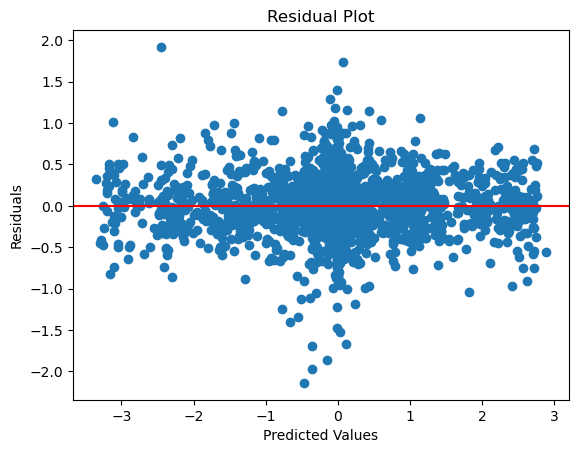

In [300]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 25)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(25, 50)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(50, 75)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(75, 100)
        self.gelu4 = nn.GELU()
        self.fc5 = nn.Linear(100, 75)
        self.gelu5 = nn.GELU()
        self.fc6 = nn.Linear(75, 50)
        self.gelu6 = nn.GELU()
        self.fc7 = nn.Linear(50, 25)
        self.gelu7 = nn.GELU()
        self.fc8 = nn.Linear(25, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.fc2(x)
        x = self.gelu2(x)
        x = self.fc3(x)
        x = self.gelu3(x)
        x = self.fc4(x)
        x = self.gelu4(x)
        x = self.fc5(x)
        x = self.gelu5(x)
        x = self.fc6(x)
        x = self.gelu6(x)
        x = self.fc7(x)
        x = self.gelu7(x)
        x = self.fc8(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v2, Rfu2, acc2, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    
# Make predictions using the trained model on the test set
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Mean Absolute Error: 0.2473744061343627
Mean Squared Error: 0.11508623996177907
0.07383980682327815 0.0875031263894349 0.18229260492031804


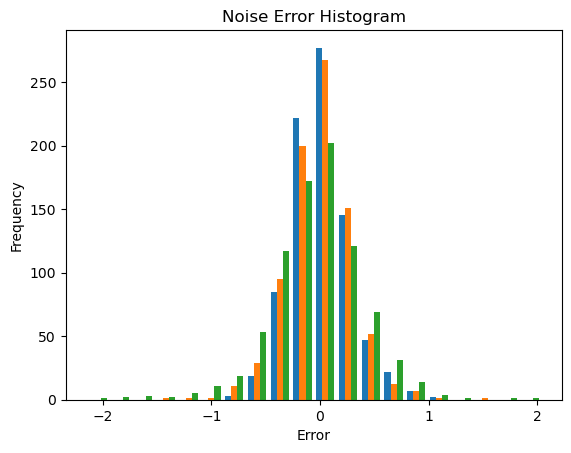

In [301]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v2, Rfu2, acc2, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)

# Make predictions using the trained model on the test set
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(acc_test, accel_pred_test)
mse = mean_squared_error(acc_test, accel_pred_test)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))
# Plot a histogram of the errors
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


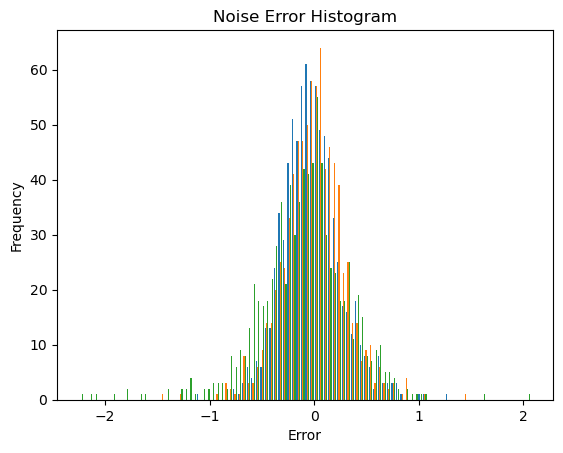

In [78]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#### Model4 (v2)

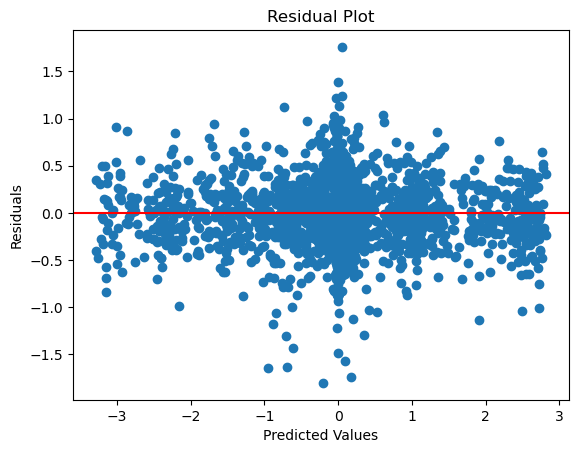

In [104]:
from sklearn.model_selection import train_test_split

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(10, 25)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(25, 50)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(50, 75)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(75, 100)
        self.gelu4 = nn.GELU()
        self.fc5 = nn.Linear(100, 75)
        self.gelu5 = nn.GELU()
        self.fc6 = nn.Linear(75, 50)
        self.gelu6 = nn.GELU()
        self.fc7 = nn.Linear(50, 25)
        self.gelu7 = nn.GELU()
        self.fc8 = nn.Linear(25, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.fc2(x)
        x = self.gelu2(x)
        x = self.fc3(x)
        x = self.gelu3(x)
        x = self.fc4(x)
        x = self.gelu4(x)
        x = self.fc5(x)
        x = self.gelu5(x)
        x = self.fc6(x)
        x = self.gelu6(x)
        x = self.fc7(x)
        x = self.gelu7(x)
        x = self.fc8(x)
        return x

model = RegressionNN()

# Define the loss function
def custom_loss(accel_pred, accel):
    loss = torch.mean((accel_pred - accel)**2)
    return loss

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Split the data into training and testing sets
v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test, pwm_train, pwm_test = train_test_split(v2, Rfu2, acc2, pwm2, test_size=0.33, random_state=42)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    for i in range(len(v_train)):
        v_i = torch.Tensor(v_train[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_train[i]).view(1, -1)
        pwm_i = torch.Tensor(pwm_train[i]).view(1,-1)
        accel_i = torch.Tensor(acc_train[i]).view(1, -1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i, pwm_i), dim=-1))
        loss_i = custom_loss(accel_pred_i, accel_i)
        loss_i.backward()
        train_loss += loss_i.item()
    optimizer.step()
    train_loss /= len(v_train)
    
# Make predictions using the trained model on the test set
model.eval()
with torch.no_grad():
    accel_pred_test = []
    for i in range(len(v_test)):
        v_i = torch.Tensor(v_test[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu_test[i]).view(1, -1)
        pwm_i = torch.Tensor(pwm_test[i]).view(1,-1)
        accel_pred_i = model(torch.cat((v_i, Rfu_i, pwm_i), dim=-1))
        accel_pred_test.append(accel_pred_i.numpy()[0])

# Calculate the residuals by subtracting the predicted values from the actual values
residuals = np.array(acc_test) - np.array(accel_pred_test)

# Plot the residuals against the predicted values
plt.scatter(accel_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

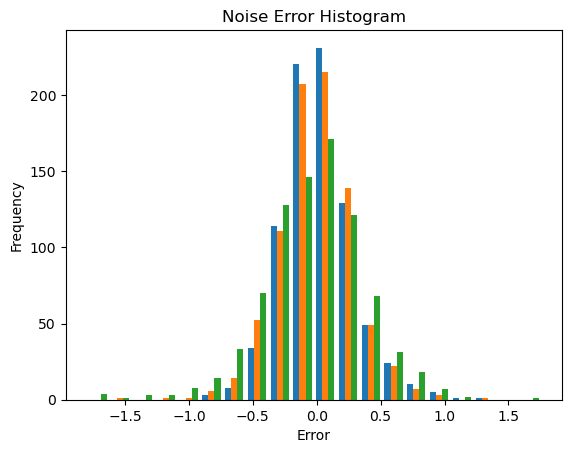

In [105]:
plt.hist(residuals, bins=20)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

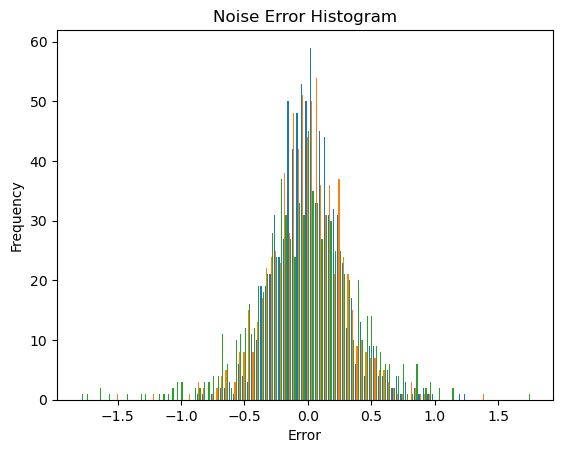

In [106]:
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [109]:
accel_prediction4 = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    test_pwm_i = torch.Tensor(pwm[i]).view(1,-1)
    accel_pred_i = model(torch.cat((test_v_i, test_Rfu_i, test_pwm_i), dim=-1))
    #print(accel_pred_i)
    accel_prediction4[i] = accel_pred_i

In [110]:
accel_prediction4 = accel_prediction4.detach().numpy()

In [111]:
def acceleration4(tk,yk):
    count = tk/0.02
    return accel_prediction4[int(count)]

In [112]:
vel4 = np.zeros((2511,3),dtype = np.float64)
yk = v2[0]
dt = 0.02
tk = 0
for ele in range(2510):
    ykplus1 = rk4(acceleration4,tk,yk,dt)
    vel4[ele] = ykplus1
    tk = tk+0.02
    yk = ykplus1 

In [113]:
def velocity4(tk,yk):
    count = tk/0.02
    return vel4[int(count)]

In [114]:
pos_reg4 = np.zeros((2511,3),dtype = np.float64)
xk = np.array([0.0,0.0,0.0])
dt = 0.02
tk = 0
for ele in range(2510):
    ykplus1 = rk4(velocity4,tk,yk,dt)
    pos_reg4[ele] = ykplus1
    tk = tk+0.02
    yk = ykplus1

In [115]:
pos_reg_dp4 = np.zeros((2509,3),dtype = np.float64)
for ele in range(2509):
    pos_reg_dp4[ele] = pos_reg4[ele]

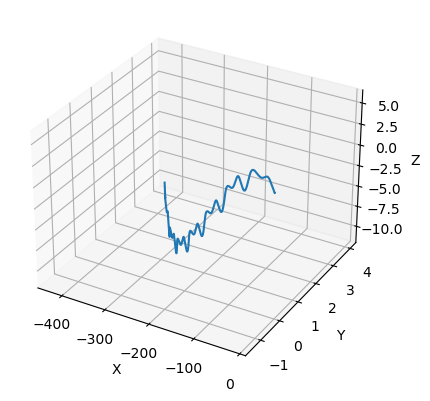

In [116]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot3D(pos_reg_dp4[:,0],pos_reg_dp4[:,1],pos_reg_dp4[:,2])
plt.show()

In [117]:
error = 0.0
for ele in range(2511):
    temp = np.square(np.subtract(acc2[ele],accel_prediction4[ele]))
    error = error + temp
error = error/2511
error

array([0.56834538, 0.08979245, 0.68875087])

#### Model5 (v2)

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(latent_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, output_dim)
        
    def forward(self, z):
        x = self.fc1(z)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define the hyperparameters
latent_dim = 20
output_dim = 6
batch_size = 32
num_epochs = 200
lr = 0.0001
clip_value = 0.01

device = torch.device('cpu')

# Create the generator and discriminator
G = Generator(latent_dim, output_dim).to(device)
D = Discriminator(output_dim).to(device)

# Define the loss functions
criterion_D = nn.BCELoss()
criterion_G = nn.MSELoss()

# Define the optimizers
optim_G = optim.Adam(G.parameters(), lr=lr)
optim_D = optim.Adam(D.parameters(), lr=lr)


# Define the training data
v_train, v_test, Rfu_train, Rfu_test = train_test_split(v2, Rfu2, test_size=0.33, random_state=42)

# Define the training data
train_data = torch.utils.data.TensorDataset(torch.Tensor(v_train), torch.Tensor(Rfu_train))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Define the training loop
for epoch in range(num_epochs):
    # Train the discriminator
    D.train()
    for real_v, real_Rfu in train_loader:
        real_data = torch.cat((real_v, real_Rfu), dim=1).to(device)
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = G(z).detach()

        # Train the discriminator on real and fake data
        D_real = D(real_data)
        D_fake = D(fake_data)
        loss_D = D_fake.mean() - D_real.mean()
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

        # Clip the weights of the discriminator
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

    # Train the generator
    G.train()
    for i in range(len(v_train)//batch_size):
        # Generate fake data
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = G(z)

        # Train the generator to fool the discriminator
        D_fake = D(fake_data)
        loss_G = -D_fake.mean()
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()

    # Print loss and save model
    if epoch % 10 == 0:
        print("Epoch: {}, Loss D: {:.4f}, Loss G: {:.4f}".format(epoch, loss_D.item(), loss_G.item()))
        torch.save(G.state_dict(), "generator2.pth")
        torch.save(D.state_dict(), "discriminator2.pth")


Epoch: 0, Loss D: -0.0002, Loss G: -0.5020
Epoch: 10, Loss D: -0.0001, Loss G: -0.5019
Epoch: 20, Loss D: -0.0005, Loss G: -0.5007
Epoch: 30, Loss D: -0.0009, Loss G: -0.5004
Epoch: 40, Loss D: -0.0021, Loss G: -0.5011
Epoch: 50, Loss D: -0.0015, Loss G: -0.5003
Epoch: 60, Loss D: -0.0004, Loss G: -0.5002
Epoch: 70, Loss D: -0.0003, Loss G: -0.4999
Epoch: 80, Loss D: -0.0001, Loss G: -0.5013
Epoch: 90, Loss D: -0.0001, Loss G: -0.4999
Epoch: 100, Loss D: 0.0000, Loss G: -0.5000
Epoch: 110, Loss D: 0.0000, Loss G: -0.5000
Epoch: 120, Loss D: 0.0000, Loss G: -0.5000
Epoch: 130, Loss D: 0.0000, Loss G: -0.5000
Epoch: 140, Loss D: 0.0000, Loss G: -0.5000
Epoch: 150, Loss D: -0.0000, Loss G: -0.5000
Epoch: 160, Loss D: 0.0000, Loss G: -0.5000
Epoch: 170, Loss D: 0.0000, Loss G: -0.5000
Epoch: 180, Loss D: 0.0000, Loss G: -0.5000
Epoch: 190, Loss D: 0.0000, Loss G: -0.5000


In [197]:
# Load the trained generator
G = Generator(latent_dim, output_dim)
G.load_state_dict(torch.load("generator2.pth"))

# Generate new data
num_samples = 2511
z = torch.randn(num_samples, latent_dim)
fake_data = G(z)
# Print the generated data
print(fake_data)

tensor([[-3.8880e-01, -1.7592e-01,  2.5773e-01,  1.6235e-01, -8.1912e-03,
          5.0168e-01],
        [-3.2913e-01, -2.8832e-01, -8.4795e-01,  3.1152e-01,  1.0218e-01,
          6.1433e-01],
        [ 2.7111e-01, -3.7289e-02, -2.3838e-01,  1.7557e-01, -2.6283e-02,
          3.4292e-01],
        ...,
        [ 5.2060e-01, -1.4711e-01,  9.9047e-01,  1.3586e-01, -6.5438e-02,
          3.3217e-01],
        [ 5.3916e-01, -1.4276e-01, -8.4748e-01,  2.7029e-01,  8.7263e-02,
          4.2669e-01],
        [-6.5328e-04, -3.6081e-02,  1.5715e-01,  8.5652e-02, -3.8116e-02,
          3.2534e-01]], grad_fn=<AddmmBackward0>)


In [204]:
print(type(fake_data))

<class 'torch.Tensor'>


In [205]:
data_fake = fake_data.detach().numpy()

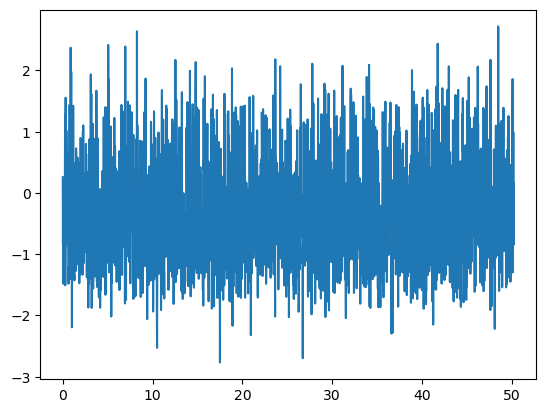

In [209]:
plt.plot(t,data_fake[:,2])
plt.show()

#### Putting fake data with no apparent pattern through SINDy

In [182]:
import pysindy as ps

In [212]:
v_fake = data_fake[:,0:3]
Rfu_fake = data_fake[:,3:]

In [216]:
acc_fake = np.zeros((2511,3),dtype = np.float32) # actual acceleration
for ele in range(2510):
    acc_fake[ele] = (v_fake[ele+1]-v_fake[ele])/0.02
acc_fake[2510] = acc_fake[2509]

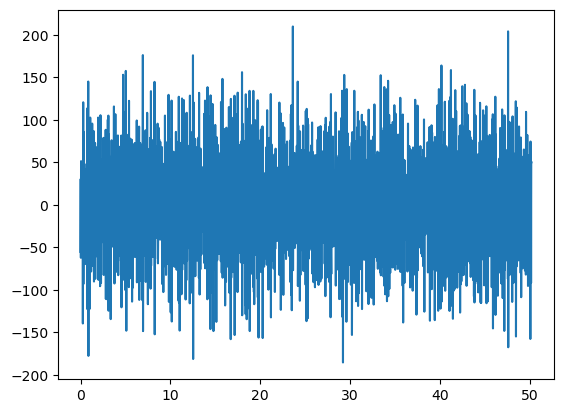

In [219]:
plt.plot(t,acc_fake[:,2])
plt.show()

In [225]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.85, alpha=.3)

library_functions = [
  
    lambda x : np.cos(x),
    lambda x,y : x*y,
    lambda x,y : np.sin(x)*np.sin(y),
    lambda x : np.sin(x),
    lambda x,y : np.sin(x*y)
]
library_function_names = [
   
    lambda x : '*np.cos(' + x + ')',
    lambda x,y : '*' + x + '*' + y,
    lambda x,y : '*' + 'np.sin(' + x + ')*np.sin(' + y + ')',
    lambda x : '*' + 'np.sin' +'(' + x + ')',
    lambda x,y : '*' + 'np.sin' + '(' + x + '*' + y + ')' 
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model.fit(v_fake, u=Rfu_fake, t=dt)
model.print()

(x0)' = -48.473 *np.cos(x0) + -645.235 *np.cos(u0) + 675.519 *np.cos(u2) + -100.904 *x0*x1 + 1.652 *x0*x2 + -164.051 *x0*u0 + -70.207 *x0*u2 + -92.778 *x1*x2 + 19638.422 *x1*u0 + -27551.021 *x1*u1 + -337.316 *x1*u2 + 211.678 *x2*u0 + 158.969 *x2*u1 + -24.533 *x2*u2 + 24765.357 *u0*u1 + 495.338 *u0*u2 + 1243.969 *u1*u2 + 246.891 *np.sin(x0)*np.sin(x1) + -0.518 *np.sin(x0)*np.sin(x2) + 5.812 *np.sin(x0)*np.sin(u0) + -42.116 *np.sin(x0)*np.sin(u1) + 114.080 *np.sin(x0)*np.sin(u2) + -105.231 *np.sin(x1)*np.sin(x2) + 2325.062 *np.sin(x1)*np.sin(u0) + -779.251 *np.sin(x1)*np.sin(u1) + -38.338 *np.sin(x2)*np.sin(u0) + 40.174 *np.sin(x2)*np.sin(u1) + 6.164 *np.sin(x2)*np.sin(u2) + 493.954 *np.sin(u0)*np.sin(u1) + -2553.858 *np.sin(u0)*np.sin(u2) + 3123.498 *np.sin(u1)*np.sin(u2) + -5.754 *np.sin(x2) + -54.794 *np.sin(u1) + 166.039 *np.sin(u2) + -258.764 *np.sin(x0*x1) + 35.524 *np.sin(x0*u0) + -43.290 *np.sin(x0*u2) + 210.198 *np.sin(x1*x2) + -20986.871 *np.sin(x1*u0) + 28174.430 *np.sin(x1*u1

In [229]:
accel = np.zeros((2511,3),dtype = np.float64)
for ele in range(2511):
    accel[ele][0] = -48.473 *np.cos(v_fake[ele][0]) + -645.235 *np.cos(Rfu_fake[ele][0]) + 675.519 *np.cos(Rfu_fake[ele][2]) + -100.904 *v_fake[ele][0]*v_fake[ele][1] + 1.652 *v_fake[ele][0]*v_fake[ele][2] + -164.051 *v_fake[ele][0]*Rfu_fake[ele][0] + -70.207 *v_fake[ele][0]*Rfu_fake[ele][2] + -92.778 *v_fake[ele][1]*v_fake[ele][2] + 19638.422 *v_fake[ele][1]*Rfu_fake[ele][0] + -27551.021 *v_fake[ele][1]*Rfu_fake[ele][1] + -337.316 *v_fake[ele][1]*Rfu_fake[ele][2] + 211.678 *v_fake[ele][2]*Rfu_fake[ele][0] + 158.969 *v_fake[ele][2]*Rfu_fake[ele][1] + -24.533 *v_fake[ele][2]*Rfu_fake[ele][2] + 24765.357 *Rfu_fake[ele][0]*Rfu_fake[ele][1] + 495.338 *Rfu_fake[ele][0]*Rfu_fake[ele][2] + 1243.969 *Rfu_fake[ele][1]*Rfu_fake[ele][2] + 246.891 *np.sin(v_fake[ele][0])*np.sin(v_fake[ele][1]) + -0.518 *np.sin(v_fake[ele][0])*np.sin(v_fake[ele][2]) + 5.812 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][0]) + -42.116 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][1]) + 114.080 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][2]) + -105.231 *np.sin(v_fake[ele][1])*np.sin(v_fake[ele][2]) + 2325.062 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][0]) + -779.251 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][1]) + -38.338 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][0]) + 40.174 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][1]) + 6.164 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][2]) + 493.954 *np.sin(Rfu_fake[ele][0])*np.sin(Rfu_fake[ele][1]) + -2553.858 *np.sin(Rfu_fake[ele][0])*np.sin(Rfu_fake[ele][2]) + 3123.498 *np.sin(Rfu_fake[ele][1])*np.sin(Rfu_fake[ele][2]) + -5.754 *np.sin(v_fake[ele][2]) + -54.794 *np.sin(Rfu_fake[ele][1]) + 166.039 *np.sin(Rfu_fake[ele][2]) + -258.764 *np.sin(v_fake[ele][1]*v_fake[ele][0]) + 35.524 *np.sin(v_fake[ele][0]*Rfu_fake[ele][0]) + -43.290 *np.sin(v_fake[ele][0]*Rfu_fake[ele][2]) + 210.198 *np.sin(v_fake[ele][1]*v_fake[ele][2]) + -20986.871 *np.sin(v_fake[ele][1]*Rfu_fake[ele][0]) + 28174.430 *np.sin(Rfu_fake[ele][1]*v_fake[ele][1]) + -220.910 *np.sin(v_fake[ele][2]*Rfu_fake[ele][0]) + -171.204 *np.sin(Rfu_fake[ele][1]*v_fake[ele][2]) + 51.008 *np.sin(v_fake[ele][2]*Rfu_fake[ele][2]) + -25433.393 *np.sin(Rfu_fake[ele][1]*Rfu_fake[ele][0]) + 1965.045 *np.sin(Rfu_fake[ele][0]*Rfu_fake[ele][2]) + -3930.963 *np.sin(Rfu_fake[ele][1]*Rfu_fake[ele][2])
    
for ele in range(2511):
    accel[ele][1] = 4.197 *v_fake[ele][0]*Rfu_fake[ele][0] + -5.664 *v_fake[ele][0]*Rfu_fake[ele][2] + -217.073 *v_fake[ele][1]*Rfu_fake[ele][0] + -3.076 *v_fake[ele][1]*Rfu_fake[ele][2] + -9.833 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][0]) + 6.086 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][2]) + -34.550 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][0]) + 5.138 *np.sin(v_fake[ele][0]*Rfu_fake[ele][0]) + 258.368 *np.sin(v_fake[ele][1]*Rfu_fake[ele][0])
    
for ele in range(2511):
    accel[ele][2] = 13.449 *np.cos(v_fake[ele][0]) + 1121.506 *np.cos(v_fake[ele][1]) + 4.878 *np.cos(v_fake[ele][2]) + -1036.238 *np.cos(Rfu_fake[ele][1]) + -13.295 *np.cos(Rfu_fake[ele][2]) + 15.400 *v_fake[ele][0]*v_fake[ele][1] + 7.447 *v_fake[ele][0]*v_fake[ele][2] + -11.299 *v_fake[ele][0]*Rfu_fake[ele][0] + 1958.624 *v_fake[ele][0]*Rfu_fake[ele][1] + -80.417 *v_fake[ele][0]*Rfu_fake[ele][2] + -25.441 *v_fake[ele][1]*v_fake[ele][2] + 7452.176 *v_fake[ele][1]*Rfu_fake[ele][0] + -144542.531 *v_fake[ele][1]*Rfu_fake[ele][1] + -3652.903 *v_fake[ele][1]*Rfu_fake[ele][2] + -113.320 *v_fake[ele][2]*Rfu_fake[ele][0] + 129.404 *v_fake[ele][2]*Rfu_fake[ele][1] + -3.118 *v_fake[ele][2]*Rfu_fake[ele][2] + 43704.434 *Rfu_fake[ele][0]*Rfu_fake[ele][1] + 1349.325 *Rfu_fake[ele][0]*Rfu_fake[ele][2] + -58648.641 *Rfu_fake[ele][1]*Rfu_fake[ele][2] + 9.060 *np.sin(v_fake[ele][0])*np.sin(v_fake[ele][2]) + 161.508 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][0]) + 92.136 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][1]) + -232.320 *np.sin(v_fake[ele][0])*np.sin(Rfu_fake[ele][2]) + -21.949 *np.sin(v_fake[ele][1])*np.sin(v_fake[ele][2]) + 12178.498 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][0]) + -7612.833 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][1]) + -5082.846 *np.sin(v_fake[ele][1])*np.sin(Rfu_fake[ele][2]) + -92.530 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][0]) + 105.812 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][1]) + -48.372 *np.sin(v_fake[ele][2])*np.sin(Rfu_fake[ele][2]) + 12388.353 *np.sin(Rfu_fake[ele][0])*np.sin(Rfu_fake[ele][1]) + 4177.359 *np.sin(Rfu_fake[ele][0])*np.sin(Rfu_fake[ele][2]) + -11871.874 *np.sin(Rfu_fake[ele][1])*np.sin(Rfu_fake[ele][2]) + 31.428 * np.sin(v_fake[ele][0]) +-326.531 * np.sin(Rfu_fake[ele][0]) +599.292 * np.sin(Rfu_fake[ele][1]) +-348.070 * np.sin(Rfu_fake[ele][2]) +-38.303 * np.sin(v_fake[ele][0] * v_fake[ele][1]) +-59.828 * np.sin(v_fake[ele][0] * Rfu_fake[ele][0]) +-1792.898 * np.sin(v_fake[ele][0] * Rfu_fake[ele][1]) +133.091 * np.sin(v_fake[ele][0] * Rfu_fake[ele][2]) +4.293 * np.sin(v_fake[ele][1] * v_fake[ele][2]) +-18176.607 * np.sin(v_fake[ele][1] * Rfu_fake[ele][0]) +150480.781 * np.sin(v_fake[ele][1] * Rfu_fake[ele][1]) +7807.255 * np.sin(v_fake[ele][1] * Rfu_fake[ele][2]) +186.747 * np.sin(v_fake[ele][2] * Rfu_fake[ele][0]) +-331.847 * np.sin(v_fake[ele][2] * Rfu_fake[ele][1]) +41.072 * np.sin(v_fake[ele][2] * Rfu_fake[ele][2]) +-57002.191 * np.sin(Rfu_fake[ele][0] * Rfu_fake[ele][1]) +-3971.263 * np.sin(Rfu_fake[ele][0] * Rfu_fake[ele][2]) +68568.711 * np.sin(Rfu_fake[ele][1] * Rfu_fake[ele][2])

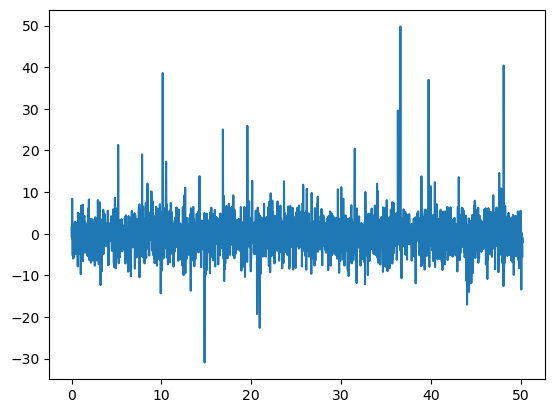

In [231]:
plt.plot(t,accel[:,2])
plt.show()

In [234]:
#mse
errorx = 0.0
for ele in range(2510):
    temp = np.square(np.subtract(accel[ele][0],acc_fake[ele][0]))
    errorx = errorx + temp
errorx = errorx/2510
print(errorx)

errory = 0.0
for ele in range(2510):
    temp = np.square(np.subtract(accel[ele][1],acc_fake[ele][1]))
    errory = errory + temp
errory = errory/2510
print(errory)

errorz= 0.0
for ele in range(2510):
    temp = np.square(np.subtract(accel[ele][2],acc_fake[ele][2]))
    errorz= errorz+ temp
errorz= errorz/2510
print(errorz)

2120.782245150164
48.16790550711727
3488.064799486479


In [233]:
accel

array([[-5.50889079e+00,  7.92416007e-02,  1.53223331e+00],
       [-3.14404226e+00, -9.25698525e-02, -9.07098034e-01],
       [ 1.02588271e+00, -2.99934602e-04,  2.07944755e+00],
       ...,
       [-1.66801519e+00,  1.64409559e-02, -5.60940851e+00],
       [ 2.14376095e+00, -9.11645928e-02, -9.11392933e-01],
       [-9.07194733e-01,  1.50714825e-02, -2.04106381e+00]])